In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import keras
from keras import layers

import tensorflow as tf
from keras.optimizers import AdamW

2025-06-21 06:19:05.882188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750486746.031929      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750486746.074389      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!wget https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
!unzip -q lol_dataset.zip && rm lol_dataset.zip

--2025-06-21 06:19:17--  https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
Resolving huggingface.co (huggingface.co)... 65.8.243.16, 65.8.243.46, 65.8.243.90, ...
Connecting to huggingface.co (huggingface.co)|65.8.243.16|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/d9/09/d909ef7668bb417b7065a311bd55a3084cc83a1f918e13cb41c5503328432db2/419fddc48958cd0f5599939ee0248852a37ceb8bb738c9b9525e95b25a89de9a?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27lol_dataset.zip%3B+filename%3D%22lol_dataset.zip%22%3B&response-content-type=application%2Fzip&Expires=1750490357&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MDQ5MDM1N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9kOS8wOS9kOTA5ZWY3NjY4YmI0MTdiNzA2NWEzMTFiZDU1YTMwODRjYzgzYTFmOTE4ZTEzY2I0MWM1NTAzMzI4NDMyZGIyLzQxOWZkZGM0ODk1OGNkMGY1NTk5OTM5ZWUwMjQ4ODUyYTM3Y2ViOGJiNzM4YzliOTUyNWU5N

In [3]:
from glob import glob

IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400

def load_image_pair(low_path, high_path):
    low_image = tf.io.read_file(low_path)
    low_image = tf.image.decode_png(low_image, channels=3)
    low_image = tf.image.resize(low_image, [IMAGE_SIZE, IMAGE_SIZE])
    low_image = low_image / 255.0

    high_image = tf.io.read_file(high_path)
    high_image = tf.image.decode_png(high_image, channels=3)
    high_image = tf.image.resize(high_image, [IMAGE_SIZE, IMAGE_SIZE])
    high_image = high_image / 255.0

    return low_image, high_image

def data_generator(low_paths, high_paths):
    dataset = tf.data.Dataset.from_tensor_slices((low_paths, high_paths))
    dataset = dataset.map(load_image_pair, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


# Paths
train_low = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_high = sorted(glob("./lol_dataset/our485/high/*"))[:MAX_TRAIN_IMAGES]

val_low = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_high = sorted(glob("./lol_dataset/our485/high/*"))[MAX_TRAIN_IMAGES:]

test_low = sorted(glob("./lol_dataset/eval15/low/*"))
test_high = sorted(glob("./lol_dataset/eval15/high/*"))

# Datasets
train_dataset = data_generator(train_low, train_high)
val_dataset = data_generator(val_low, val_high)
test_dataset = data_generator(test_low, test_high)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)


Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None))>


I0000 00:00:1750486762.547667      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750486762.548357      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
from tensorflow.keras import layers

# Channel Attention Module
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_layer_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)

    return layers.Multiply()([input_feature, cbam_feature])

# Spatial Attention Module
def spatial_attention(input_feature):
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_feature)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_feature)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    cbam_feature = layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal')(concat)

    return layers.Multiply()([input_feature, cbam_feature])

# CBAM Block
def cbam_block(input_feature, ratio=8):
    attention_feature = channel_attention(input_feature, ratio)
    attention_feature = spatial_attention(attention_feature)
    return attention_feature


In [5]:
# definig Denoising NAFBlock 

class NAFBlock(tf.keras.layers.Layer):
    def __init__(self, channels, dropout_rate=0.0):
        super().__init__()
        self.norm1 = layers.LayerNormalization()
        self.conv1 = layers.Conv2D(channels, 1, padding='same')
        self.conv2 = layers.DepthwiseConv2D(3, padding='same')
        self.conv3 = layers.Conv2D(channels, 1, padding='same')
        self.gamma = self.add_weight(shape=(1, 1, 1, channels), initializer='zeros', trainable=True)

    def call(self, x):
        residual = x
        x = self.norm1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return residual + self.gamma * x


In [6]:
def add_denoising_module(enhanced_input, num_blocks=3, channels=24):
    x = enhanced_input
    for _ in range(num_blocks):
        x = NAFBlock(channels)(x)
    return x

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# Define Mish activation as a custom Keras Layer
class Mish(layers.Layer):
    def call(self, inputs):
        return inputs * tf.math.tanh(tf.math.softplus(inputs))

def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])

    conv1 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same")(input_img)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = cbam_block(conv1)
    conv1 = Mish()(conv1)

    conv2 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same")(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = cbam_block(conv2)
    conv2 = Mish()(conv2)

    conv3 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = cbam_block(conv3)
    conv3 = Mish()(conv3)

    conv4 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same")(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = cbam_block(conv4)
    conv4 = Mish()(conv4)

    int_con1 = layers.Concatenate(axis=-1)([conv4, conv1])
    conv5 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same")(int_con1)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = cbam_block(conv5)
    conv5 = Mish()(conv5)

    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same")(int_con2)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = cbam_block(conv6)
    conv6 = Mish()(conv6)

    int_con3 = layers.Concatenate(axis=-1)([conv6, conv3])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(int_con3)

    # Added NAF-based denoising after enhancement
    denoised_output = add_denoising_module(x_r)
    
    return keras.Model(inputs=input_img, outputs=denoised_output)


In [8]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = (
        mean_rgb[:, :, :, 0],
        mean_rgb[:, :, :, 1],
        mean_rgb[:, :, :, 2],
    )
    d_rg = tf.square(mr - mg)
    d_rb = tf.square(mr - mb)
    d_gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(d_rg) + tf.square(d_rb) + tf.square(d_gb))

In [9]:
def exposure_loss(x, mean_val=0.55):
  # mean_val is change from 0.6 to 0.56
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))

In [10]:
def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

In [11]:
from tensorflow import keras
import tensorflow as tf

class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(reduction="none")

        # Define directional kernels
        self.kernels = {
            'left': tf.constant([[[0], [-1], [1]]], dtype=tf.float32),
            'right': tf.constant([[[1], [-1], [0]]], dtype=tf.float32),
            'up': tf.constant([[[0], [-1], [1]]], dtype=tf.float32),
            'down': tf.constant([[[1], [-1], [0]]], dtype=tf.float32),
            'top_left': tf.constant([[1, 0, 0],
                                     [0, -1, 0],
                                     [0, 0, 0]], dtype=tf.float32),
            'top_right': tf.constant([[0, 0, 1],
                                      [0, -1, 0],
                                      [0, 0, 0]], dtype=tf.float32),
            'bottom_left': tf.constant([[0, 0, 0],
                                        [0, -1, 0],
                                        [1, 0, 0]], dtype=tf.float32),
            'bottom_right': tf.constant([[0, 0, 0],
                                         [0, -1, 0],
                                         [0, 0, 1]], dtype=tf.float32)
        }

        # Reshape kernels to [H, W, in_channels, out_channels]
        for k in self.kernels:
            kernel = self.kernels[k]
            if len(kernel.shape) == 2:  # e.g., 3x3
                self.kernels[k] = tf.reshape(kernel, [3, 3, 1, 1])
            elif len(kernel.shape) == 3:  # e.g., 3x1 or 1x3
                shape = kernel.shape
                self.kernels[k] = tf.reshape(kernel, [shape[1], shape[0], 1, 1])

    def call(self, y_true, y_pred):
        # Ensure inputs are 4D: [batch, height, width, channels]
        if len(y_true.shape) != 4:
            y_true = tf.reshape(y_true, [-1, y_true.shape[-3], y_true.shape[-2], y_true.shape[-1]])
        if len(y_pred.shape) != 4:
            y_pred = tf.reshape(y_pred, [-1, y_pred.shape[-3], y_pred.shape[-2], y_pred.shape[-1]])

        # Convert to grayscale by averaging across channels
        original_mean = tf.reduce_mean(y_true, axis=3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, axis=3, keepdims=True)

        # Downsample to stabilize the difference
        original_pool = tf.nn.avg_pool2d(original_mean, ksize=4, strides=4, padding="VALID")
        enhanced_pool = tf.nn.avg_pool2d(enhanced_mean, ksize=4, strides=4, padding="VALID")

        loss = 0.0
        for direction, kernel in self.kernels.items():
            d_orig = tf.nn.conv2d(original_pool, kernel, strides=1, padding="SAME")
            d_enh = tf.nn.conv2d(enhanced_pool, kernel, strides=1, padding="SAME")
            loss += tf.square(d_orig - d_enh)

        return loss


In [12]:
# here is PSNR metrics code
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [13]:
# code for ssim metrics 
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [16]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
      # make a architure of zero-dce net :
        super().__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super().compile(**kwargs)
        # here we making the varibale we need further.
        self.optimizer = AdamW(learning_rate=learning_rate, weight_decay=1e-5)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.illumination_smoothness_loss_tracker = keras.metrics.Mean(
            name="illumination_smoothness_loss"
        )
        self.spatial_constancy_loss_tracker = keras.metrics.Mean(
            name="spatial_constancy_loss"
        )
        self.color_constancy_loss_tracker = keras.metrics.Mean(
            name="color_constancy_loss"
        )
        self.exposure_loss_tracker = keras.metrics.Mean(name="exposure_loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")
        self.ssim_metric = keras.metrics.Mean(name="ssim")
        

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.illumination_smoothness_loss_tracker,
            self.spatial_constancy_loss_tracker,
            self.color_constancy_loss_tracker,
            self.exposure_loss_tracker,
            self.psnr_metric,
            self.ssim_metric
        ]

    def get_enhanced_image(self, data, output):
        # as we have low light and high light both data,
        low_light_data = data[0]
        high_light_data = data[1]
        # x is low light and y is high light data 
        
      # there below are the dce-net output ->> 24 parameter in a pair of 3(RGB) channel
      # complete batch, all row, all col, RGB(3 channel output), output from dce-net in 8 iteration
      # these below are the parameter map
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]

        # formula of update is :
        # i go from 2 to 9., r is parameteric map
        # I(i)(x, y, c) = I(i)(x, y, c) + r(i)*I(i-1)(x, y, c)*(1 - I(i-1)(x, y, c))
        # modified as that is used below is :
        #  I(i) = I(i-1) + r(i) * (I(i-1)^2 - I(i-1))-----> same as above
        # data can assumed to be our original image,
        # thise data is just color code of three channel, but /255(to bring in range[0,1])
        x = low_light_data + r1 * (tf.square(low_light_data) - low_light_data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        low_light_data = data[0]
        # high_light_data = data[1]
        output = self.dce_model(low_light_data)
        enhanced_image = self.get_enhanced_image(data, output)
        return enhanced_image, output

    def compute_losses(self, data, output):
        low_light_data, high_light_data = data
        enhanced_image = self.get_enhanced_image(data, output)

        # Compute individual losses
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(self.spatial_constancy_loss(high_light_data, enhanced_image))
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))

        # Total loss
        total_loss = loss_illumination + loss_spatial_constancy + loss_color_constancy + loss_exposure

        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
            }



    # Here we perform backprogagration, we call the funtion, we got the output, we got the losses,
    #  now we have update those weight accordingly
    def train_step(self, data):
        low_light_data = data[0]
        high_light_data = data[1]
        with tf.GradientTape() as tape:
            output = self.dce_model(low_light_data)
            enhanced_image = self.get_enhanced_image(data, output)
            losses = self.compute_losses(data, output)
            

        # this output is not the enhanced_image it is the raw output of dce-net
        # send the loss, and weights value to tf.Gradient, this will find the gradient of loss funtion
        # w.r.t. zeach weight, use adam optimizer funtion and we store updated weights in gradients
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        # now we upadate our weights,
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))

        # as weights are updated, now we update the metrics results.
        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(
            losses["illumination_smoothness_loss"]
        )
        self.spatial_constancy_loss_tracker.update_state(
            losses["spatial_constancy_loss"]
        )
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        # PSNR and SSIM updates
        self.psnr_metric.update_state(tf.image.psnr(high_light_data, enhanced_image, max_val=1.0))
        self.ssim_metric.update_state(tf.image.ssim(high_light_data, enhanced_image, max_val=1.0))

        return {
            "total_loss": self.total_loss_tracker.result(),
            "illumination_smoothness_loss": self.illumination_smoothness_loss_tracker.result(),
            "spatial_constancy_loss": self.spatial_constancy_loss_tracker.result(),
            "color_constancy_loss": self.color_constancy_loss_tracker.result(),
            "exposure_loss": self.exposure_loss_tracker.result(),
            "psnr": self.psnr_metric.result(),
            "ssim": self.ssim_metric.result(),
            }

    def test_step(self, data):
        low_light_data = data[0]
        high_light_data = data[1]
        output = self.dce_model(low_light_data)
        losses = self.compute_losses((low_light_data, high_light_data), output)
        enhanced_image = self.get_enhanced_image(low_light_data, output)
    
        # Update all tracked metrics
        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(losses["illumination_smoothness_loss"])
        self.spatial_constancy_loss_tracker.update_state(losses["spatial_constancy_loss"])
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])
        
        self.psnr_metric.update_state(tf.image.psnr(high_light_data, enhanced_image, max_val=1.0))
        self.ssim_metric.update_state(tf.image.ssim(high_light_data, enhanced_image, max_val=1.0))
    
        return {
            "total_loss": self.total_loss_tracker.result(),
            "illumination_smoothness_loss": self.illumination_smoothness_loss_tracker.result(),
            "spatial_constancy_loss": self.spatial_constancy_loss_tracker.result(),
            "color_constancy_loss": self.color_constancy_loss_tracker.result(),
            "exposure_loss": self.exposure_loss_tracker.result(),
            "psnr": self.psnr_metric.result(),
            "ssim": self.ssim_metric.result(),
        }

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )

In [17]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=60)




Epoch 1/60


I0000 00:00:1750486916.220336     101 service.cc:148] XLA service 0x7b6ec4093770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750486916.220951     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750486916.220970     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1750486917.507314     101 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1750486917.508390     101 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1750486917.510064     101 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1750486917.510806     101 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1750486917.511742     101 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1750486917.512395     101 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Asse

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - color_constancy_loss: 0.0030 - exposure_loss: 2.4766 - illumination_smoothness_loss: 3.0540e-04 - psnr: 7.1468 - spatial_constancy_loss: 0.0771 - ssim: 0.1590 - total_loss: 2.5570

W0000 00:00:1750486948.175174      99 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1750486948.176242      99 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1750486948.178072      99 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1750486948.178860      99 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1750486948.179830      99 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1750486948.180441      99 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert


25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 548ms/step - color_constancy_loss: 0.0030 - exposure_loss: 2.4747 - illumination_smoothness_loss: 3.2260e-04 - psnr: 7.1588 - spatial_constancy_loss: 0.0770 - ssim: 0.1595 - total_loss: 2.5550 - val_color_constancy_loss: 0.0023 - val_exposure_loss: 2.4238 - val_illumination_smoothness_loss: 0.0027 - val_psnr: 9.1641 - val_spatial_constancy_loss: 0.0478 - val_ssim: 0.1528 - val_total_loss: 2.4765
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step - color_constancy_loss: 0.0032 - exposure_loss: 2.4499 - illumination_smoothness_loss: 0.0058 - psnr: 7.2423 - spatial_constancy_loss: 0.0759 - ssim: 0.1676 - total_loss: 2.5348 - val_color_constancy_loss: 0.0026 - val_exposure_loss: 2.3843 - val_illumination_smoothness_loss: 0.0210 - val_psnr: 9.2594 - val_spatial_constancy_loss: 0.0462 - val_ssim: 0.1596 - val_total_loss: 2.4542
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - color_constancy_loss: 0.0036 - exposure_loss: 2.4171 - illumination_smoothness

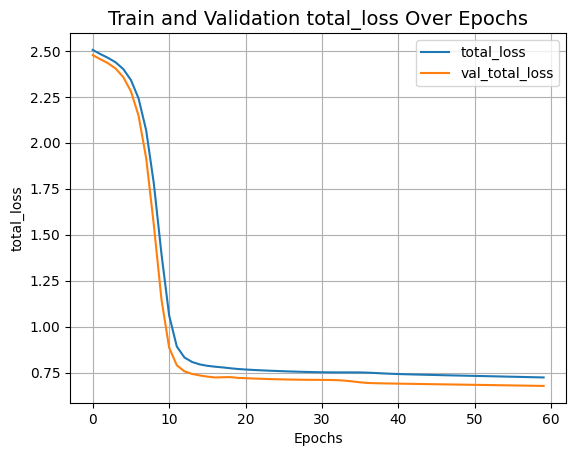

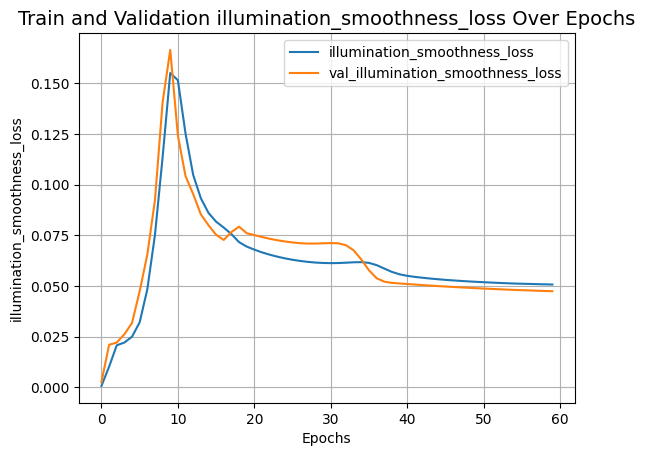

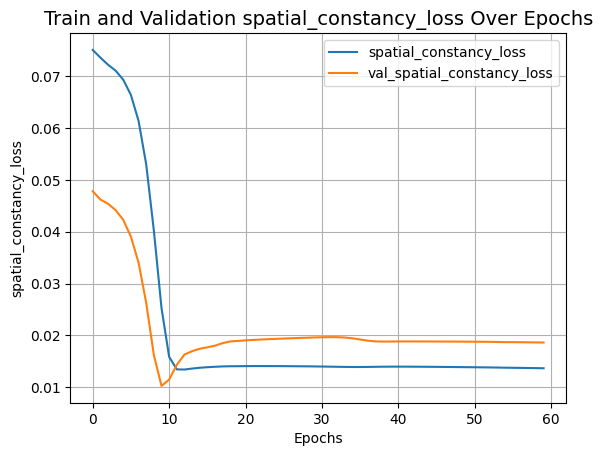

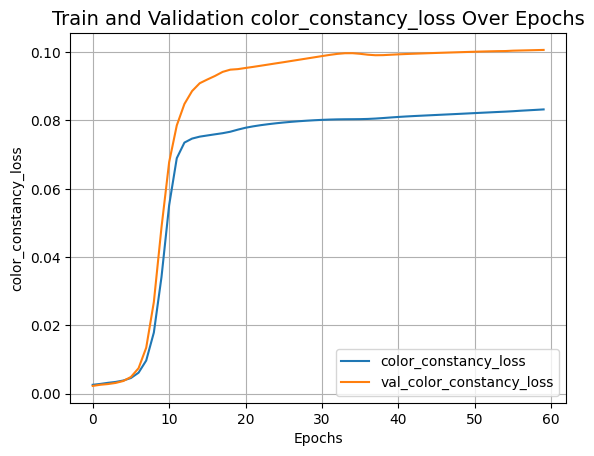

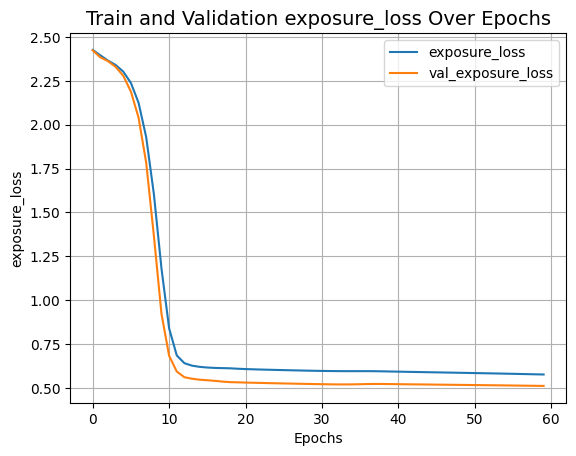

In [18]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow import keras


def plot_results(images, titles, figure_size=(20, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        ax = fig.add_subplot(1, len(images), i + 1)
        ax.set_title(titles[i])
        ax.imshow(images[i])
        ax.axis("off")
    plt.show()

def infer(original_image):
    image = keras.utils.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)  # shape: (1, H, W, 3)

    # Run model
    output = zero_dce_model(image)  # model handles full 4D input now
    enhanced = zero_dce_model.get_enhanced_image(image, output)

    # PSNR and SSIM
    psnr = tf.image.psnr(image, enhanced, max_val=1.0).numpy().mean()
    ssim = tf.image.ssim(image, enhanced, max_val=1.0).numpy().mean()

    # Format for display
    enhanced_image = tf.cast(enhanced[0] * 255, dtype=tf.uint8)
    enhanced_image = Image.fromarray(enhanced_image.numpy())

    return enhanced_image, psnr, ssim


# Inference loop
for val_image_file in test_low:
    original_image = Image.open(val_image_file).convert("RGB")
    enhanced_image, psnr, ssim = infer(original_image)

    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        [
            "Original",
            "PIL Autocontrast",
            f"Enhanced\nPSNR: {psnr:.2f}, SSIM: {ssim:.3f}"
        ],
        (20, 12),
    )


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input [[[0.08627451 0.14509805 0.15294118]
  [0.11764706 0.1764706  0.21568628]
  [0.12156863 0.16862746 0.21568628]
  ...
  [0.11372549 0.14901961 0.16470589]
  [0.11764706 0.13333334 0.15686275]
  [0.10980392 0.14117648 0.15294118]]

 [[0.11764706 0.15294118 0.1882353 ]
  [0.13333334 0.16862746 0.2       ]
  [0.1254902  0.18431373 0.21568628]
  ...
  [0.1254902  0.14509805 0.16078432]
  [0.10588235 0.14509805 0.15686275]
  [0.12941177 0.14509805 0.16078432]]

 [[0.1254902  0.18039216 0.20784314]
  [0.13333334 0.16862746 0.19607843]
  [0.13333334 0.18431373 0.21960784]
  ...
  [0.11764706 0.14509805 0.14901961]
  [0.12156863 0.14509805 0.16078432]
  [0.11764706 0.14117648 0.14901961]]

 ...

 [[0.00392157 0.01960784 0.04705882]
  [0.         0.01176471 0.03921569]
  [0.00392157 0.01176471 0.05490196]
  ...
  [0.20784314 0.3019608  0.36862746]
  [0.2        0.29411766 0.37254903]
  [0.21568628 0.30980393 0.3647059 ]]

 [[0.         0.02745098 0.04313726]
  [0.00784314 0.02352941 0.03921569]
  [0.00392157 0.01176471 0.03921569]
  ...
  [0.20784314 0.30588236 0.37254903]
  [0.21568628 0.29803923 0.37254903]
  [0.22745098 0.3019608  0.38039216]]

 [[0.00392157 0.01568628 0.05098039]
  [0.         0.01568628 0.03921569]
  [0.         0.01568628 0.03137255]
  ...
  [0.20784314 0.30980393 0.36862746]
  [0.21960784 0.30588236 0.36862746]
  [0.20392157 0.3019608  0.36862746]]]. Expected shape (None, None, None, 3), but input has incompatible shape (400, 600, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(400, 600, 3), dtype=float32)
  • training=None
  • mask=None

In [20]:
for val_image_file in test_low_light_images:
    original_image = Image.open(val_image_file)
    enhanced_image = infer(original_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", "Enhanced"],
        (20, 12),
    )

NameError: name 'test_low_light_images' is not defined

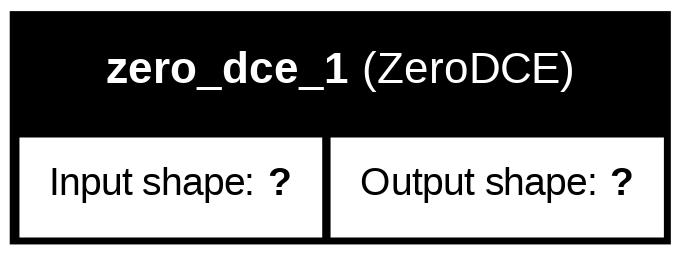

In [21]:
from tensorflow.keras.utils import plot_model

plot_model(zero_dce_model, to_file='model_.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image(retina=True, filename='model_.png')

In [22]:
from PIL import Image

# Load your custom image (low-light)
your_image5 = Image.open("/kaggle/input/image-data/image13.jpeg")

In [23]:
# Resize the image to 256x256 before inferencing
resized_image5 = your_image5.resize((IMAGE_SIZE, IMAGE_SIZE))
enhanced_image5 = infer(resized_image5)

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input [[[0.01960784 0.01176471 0.02352941]
  [0.01176471 0.00392157 0.01568628]
  [0.01568628 0.00784314 0.01960784]
  ...
  [0.00784314 0.00784314 0.01176471]
  [0.00784314 0.00784314 0.01568628]
  [0.00784314 0.00784314 0.01568628]]

 [[0.01960784 0.01176471 0.02352941]
  [0.01960784 0.01176471 0.02352941]
  [0.01960784 0.01176471 0.02352941]
  ...
  [0.00784314 0.00784314 0.01176471]
  [0.00784314 0.00784314 0.01568628]
  [0.00784314 0.00784314 0.01568628]]

 [[0.01960784 0.01176471 0.02352941]
  [0.02352941 0.01568628 0.02745098]
  [0.02352941 0.01568628 0.02745098]
  ...
  [0.00784314 0.00784314 0.01176471]
  [0.00784314 0.00784314 0.01568628]
  [0.00784314 0.00784314 0.01568628]]

 ...

 [[0.01568628 0.00784314 0.01176471]
  [0.01568628 0.00784314 0.00784314]
  [0.01568628 0.00784314 0.01568628]
  ...
  [0.00392157 0.00392157 0.00784314]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]]

 [[0.01176471 0.00392157 0.00784314]
  [0.01568628 0.00784314 0.01176471]
  [0.01568628 0.00784314 0.01568628]
  ...
  [0.00784314 0.00784314 0.01176471]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]]

 [[0.01176471 0.00392157 0.00784314]
  [0.01176471 0.00392157 0.00784314]
  [0.00784314 0.         0.00784314]
  ...
  [0.00784314 0.00784314 0.01176471]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]]]. Expected shape (None, None, None, 3), but input has incompatible shape (256, 256, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(256, 256, 3), dtype=float32)
  • training=None
  • mask=None

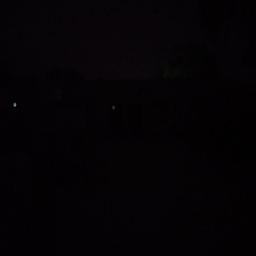

In [24]:
resized_image5

In [25]:
enhanced_image5

NameError: name 'enhanced_image5' is not defined

In [ ]:
enhanced_image.save("enhanced_result.jpg")

In [ ]:
image3 = Image.open("/content/image7.jpeg")
resized_image3 = image3.resize((IMAGE_SIZE, IMAGE_SIZE))
resized_image3

In [ ]:
enhanced_image3 = infer(resized_image3)

In [ ]:
enhanced_image3